In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from typing import Set, List, Iterable
import collections
import itertools
from numpy.random import default_rng
import numpy as np
import random
import sys
from pathlib import Path
import re
import pandas as pd
from pympler.asizeof import asizeof
from humanize.filesize import naturalsize
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
import lshexp.minhash as mh
from lshexp import shingle

<IPython.core.display.Javascript object>

In [4]:
def words_of_wiki_articles(pattern):
    words = set()
    split_reg = re.compile("\W")
    for p in Path("./data/wikipediaArticles").glob(pattern):
        with p.open("r") as f:
            for l in f.readlines():
                l = l.strip()
                if l and not l.lstrip().startswith("#"):
                    words = words.union(
                        l.strip().lower() for l in split_reg.split(l) if l.strip()
                    )
    return words

<IPython.core.display.Javascript object>

In [5]:
words = list(words_of_wiki_articles("en*.txt"))
len(words), words[:4]

(10892, ['fuse', 'hvit', 'ballistically', '1282'])

<IPython.core.display.Javascript object>

In [6]:
random.seed(42)
documents = [
    " ".join(random.choices(words, k=n_words))
    for _ in range(5000)
    for n_words in range(1, 9)
]
len(documents), naturalsize(asizeof(documents)), documents[20:25]

(40000,
 '3.9 MB',
 ['בן exclusion embark detonate assumption',
  'halides midori ouroboros hippos function election',
  'software esports rann walsingham quay spells newmarket',
  'road lords thinks enolates medium seoncheon russia hallett',
  'juives'])

<IPython.core.display.Javascript object>

In [7]:
%%time

from lshexp import shingle

shingles = [shingle.all_ngrams(s, 5) for s in documents]
len(shingles), shingles[:2]

CPU times: user 379 ms, sys: 52.8 ms, total: 432 ms
Wall time: 433 ms


(40000,
 [{'$$$$b', '$$$bm', '$$bmg', '$bmg$', 'bmg$$', 'g$$$$', 'mg$$$'},
  {' minu',
   '$$$$s',
   '$$$se',
   '$$see',
   '$seek',
   'e$$$$',
   'eeks ',
   'eks m',
   'inute',
   'ks mi',
   'minut',
   'nute$',
   's min',
   'seeks',
   'te$$$',
   'ute$$'}])

<IPython.core.display.Javascript object>

In [8]:
train = shingles[:15000]

<IPython.core.display.Javascript object>

In [9]:
from datasketch import MinHashLSH, MinHash
import murmurhash.mrmr

<IPython.core.display.Javascript object>

## Default datasketch LSH

In [75]:
j_threshold = 0.6

<IPython.core.display.Javascript object>

In [76]:
%%time
n_hashes = 128

def datasketch_minhash(shingles: List[str]):
    m = MinHash(n_hashes)
    m.update_batch([s.encode("utf8") for s in shingles])
    return m

lsh_datasketch_default = MinHashLSH(threshold=j_threshold, num_perm=n_hashes)
for i, row_shingles in enumerate(train):
    lsh_datasketch_default.insert(i, datasketch_minhash(row_shingles))
    
naturalsize(asizeof(lsh_datasketch_default))

CPU times: user 20 s, sys: 171 ms, total: 20.2 s
Wall time: 20.3 s


'98.6 MB'

<IPython.core.display.Javascript object>

In [77]:
lsh_datasketch_default.b, lsh_datasketch_default.r

(18, 7)

<IPython.core.display.Javascript object>

## Datasketch with hash function for LSH

In [78]:
# %%time
# hashfunc=murmurhash.mrmr.hash

# lsh_datasketch_murmur = MinHashLSH(threshold=j_threshold, num_perm=n_hashes, hashfunc=hashfunc)
# for i, row_shingles in enumerate(train):
#     lsh_datasketch_murmur.insert(i, datasketch_minhash(row_shingles))

# naturalsize(asizeof(lsh_datasketch_murmur))

<IPython.core.display.Javascript object>

In [79]:
# lsh_datasketch_murmur.b, lsh_datasketch_murmur.r

<IPython.core.display.Javascript object>

## Own LSH

In [234]:
from lshexp import minhash as mh

lsh_lshexp = mh.LSH(n_hashes=n_hashes, bands=lsh_datasketch_default.b)
minhash_lshexp = mh.make_minhash_generator(n_hashes=n_hashes)


def lsh_lshexp_minhash(shingles: List[str]):
    return minhash_lshexp(shingles)


lsh_lshexp.n_bands, lsh_lshexp.rows_per_band

after = minhash_lshexp(train[0])

<IPython.core.display.Javascript object>

In [235]:
# print(mh.hash32(b"askjdfklj"))
# print(type(mh.hash32(b"askjdfklj")))
# d = [b.encode("utf-8") for b in documents[:1000]]
# print(min(map(mh.hash32, d)))
# %timeit list(map(mh.hash32, d))

<IPython.core.display.Javascript object>

In [236]:
%timeit minhash_lshexp(train[0])

22.2 µs ± 81.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>

In [237]:
# %timeit datasketch_minhash(train[0]).hashvalues

<IPython.core.display.Javascript object>

In [238]:
%%time
# %%prun -s cumulative -l 20

for i, row_shingles in enumerate(train):
    lsh_lshexp.insert(lsh_lshexp_minhash(row_shingles), i)
    
naturalsize(asizeof(lsh_lshexp))

CPU times: user 3.17 s, sys: 69.7 ms, total: 3.24 s
Wall time: 3.25 s


'78.0 MB'

<IPython.core.display.Javascript object>

## Minhash algorithms from fog: Minhash

In [239]:
from lshexp import minhash as mh
import fog.lsh

lsh_fog = mh.LSH(n_hashes=n_hashes, bands=lsh_datasketch_default.b)
minhash_fog = fog.lsh.MinHash(h=n_hashes, seed=42, use_numpy=True)
minhash_fog_fn = lambda shingles: minhash_fog.create_signature(shingles)

lsh_lshexp.n_bands, lsh_lshexp.rows_per_band

(18, 7)

<IPython.core.display.Javascript object>

In [240]:
%%time

for i, row_shingles in enumerate(train):
    lsh_fog.insert(minhash_fog_fn(row_shingles), i)
    
naturalsize(asizeof(lsh_fog))

CPU times: user 3.69 s, sys: 46.6 ms, total: 3.73 s
Wall time: 3.74 s


'78.0 MB'

<IPython.core.display.Javascript object>

## Testing the LSHs

- precision
- recall
- plot jaccard-similarity -> probability to become candidate
- storage size
- indexing time
- lookup time

In [241]:
df = pd.DataFrame(
    dict(
        documents=documents,
        shingles=shingles,
    )
)
df_train = df.loc[: len(train)]
df_test = df.iloc[len(train) :].drop_duplicates(subset=["documents"]).head(10000)

len(df_train), naturalsize(asizeof(df_train)), len(df_test), naturalsize(
    asizeof(df_test)
)

(15001, '236.2 MB', 10000, '43.6 MB')

<IPython.core.display.Javascript object>

In [242]:
%%time
import lshexp.metrics

def calculate_precision(
    shingle_series, shingle_series_train, lsh_query_fn, jaccard_threshold
):
    results = shingle_series.apply(lsh_query_fn)
    #     results = candidates.loc[candidates.apply(bool)]
    n_correct = 0
    n_total = 0
    for left_shingles, candidate_list in zip(shingle_series, results):
        n_total += len(candidate_list)
        for c in candidate_list:
            right_shingles = shingle_series_train[c]
            j = lshexp.metrics.jaccard_similarity(left_shingles, right_shingles)
            if j >= jaccard_threshold:
                n_correct += 1
    if n_total == 0:
        return 1.0, 0
    return n_correct/n_total, n_total

chunk_size = 500
precisions = []
for start_index in range(0, len(df_test), chunk_size):
    precision = {
        name: calculate_precision(
            df_test["shingles"][start_index:start_index+chunk_size],
            df_train["shingles"],
            query_fn,
            j_threshold,
        )
        for name, query_fn in [
            (
                "lsh_datasketch_default",
                lambda s: lsh_datasketch_default.query(datasketch_minhash(s)),
            ),
#             (
#                 "lsh_datasketch_murmur",
#                 lambda s: lsh_datasketch_murmur.query(datasketch_minhash(s)),
#             ),
            ("lsh_lshexp", lambda s: lsh_lshexp.query(lsh_lshexp_minhash(s))),
            ("lsh_fog", lambda s: lsh_fog.query(minhash_fog_fn(s))),
#             ("lsh_fog_superminhash", lambda s: lsh_fog.query(superminhash_fog_fn(s))),
        ]
    }
    for key, v in precision.items():
        precisions.append({"algorithm": key, "precision": v[0], "support": v[1]})
test_results = pd.DataFrame.from_records(precisions)

CPU times: user 26.6 s, sys: 29.3 ms, total: 26.6 s
Wall time: 26.7 s


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='algorithm', ylabel='support'>

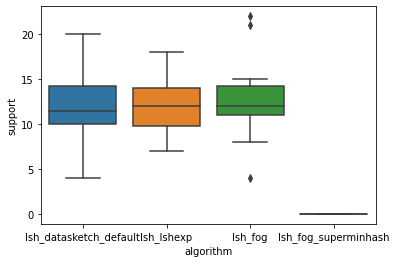

<IPython.core.display.Javascript object>

In [243]:
sns.boxplot(data=test_results, y="support", x="algorithm")

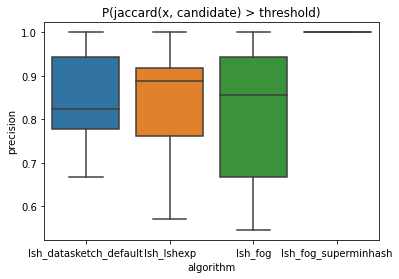

<IPython.core.display.Javascript object>

In [244]:
_ = sns.boxplot(data=test_results, y="precision", x="algorithm").set_title(
    "P(jaccard(x, candidate) > threshold)"
)

In [251]:
import random
import lshexp.metrics


def obfuscate(s: Set, other_elements: List, degree: float):
    if degree < 0.0:
        raise ValueError()
    return set(
        (x if (random.random() < degree) else random.choice(other_elements)) for x in s
    )
    return set(
        np.random.choice(
            list(
                np.random.choice(
                    list(s), size=round(len(s) * (1 - float(degree))), replace=False
                )
            )
            + list(
                np.random.choice(
                    other_elements,
                    size=round(len(s) * (1 + float(degree))),
                    replace=False,
                )
            ),
            size=len(s),
            replace=False,
        )
    )
    return set(
        random.sample(
            random.sample(list(s), k=round(len(s) * (1 - float(degree))))
            + random.sample(other_elements, k=round(len(s) * float(degree))),
            len(s),
        )
    )


def create_test_samples(train: pd.DataFrame, corpus, k):
    s = train.sample(k).reset_index(drop=True)
    s["obfuscation"] = np.random.random(len(s))
    s["test_shingles"] = s[["shingles", "obfuscation"]].apply(
        lambda row: obfuscate(row[0], corpus, row[1]), axis=1, raw=True
    )
    s["jaccard"] = s[["shingles", "test_shingles"]].apply(
        lambda row: lshexp.metrics.jaccard_similarity(*row), axis=1, raw=True
    )
    return s


def query_and_calculate_true_jaccard(
    shingle_series, shingle_series_train, lsh_query_fn
):
    return [
        lshexp.metrics.jaccard_similarity(left_shingles, shingle_series_train[c])
        for left_shingles, candidate_list in zip(
            shingle_series, shingle_series.apply(lsh_query_fn)
        )
        for c in candidate_list
    ]


obfuscate({"a", "b", "c"}, list(range(100)), 0.4)

{49, 9, 'b'}

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='rounded_jaccard'>

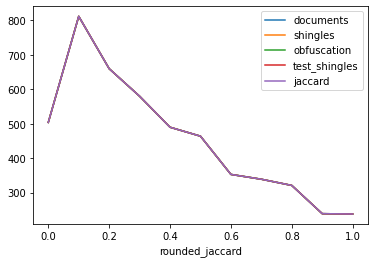

<IPython.core.display.Javascript object>

In [252]:
# corpus = list(set().union(*shingles) - set().union(*df_train.shingles))
corpus = list(range(10000000, 10001000))
df_test_samples = create_test_samples(df_train, corpus=corpus, k=5000)
df_test_samples.assign(rounded_jaccard=df_test_samples.jaccard.round(1)).groupby(
    "rounded_jaccard"
).count().plot()

In [253]:
# df_test_samples.assign(rounded_jaccard=df_test_samples.obfuscation.round(1)).groupby(
#     "obfuscation"
# ).count().plot()

<IPython.core.display.Javascript object>

In [254]:
# ((1 - df_test_samples.obfuscation) - df_test_samples.jaccard).plot(kind="hist")

<IPython.core.display.Javascript object>

In [256]:
%%time

df_test_samples = create_test_samples(
    df_train, corpus=list(set().union(*shingles)), k=5000
)
result_jaccards = {name: query_and_calculate_true_jaccard(
    df_test_samples["test_shingles"],
    df_train["shingles"],
    lambda s: query_fn(s))
    for name, query_fn in [
        (
            "lsh_datasketch_default",
            lambda s: lsh_datasketch_default.query(datasketch_minhash(s)),
        ),
#         (
#             "lsh_datasketch_murmur",
#             lambda s: lsh_datasketch_murmur.query(datasketch_minhash(s)),
#         ),
        ("lsh_lshexp", lambda s: lsh_lshexp.query(lsh_lshexp_minhash(s))),
            ("lsh_fog", lambda s: lsh_fog.query(minhash_fog_fn(s))),
#             ("lsh_fog_superminhash", lambda s: lsh_fog.query(superminhash_fog_fn(s))),
    ]
                  }

CPU times: user 7.24 s, sys: 19.8 ms, total: 7.26 s
Wall time: 7.27 s


<IPython.core.display.Javascript object>

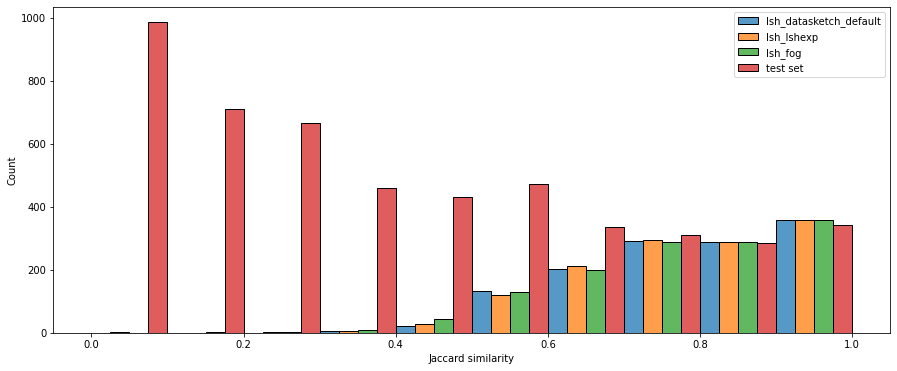

<IPython.core.display.Javascript object>

In [257]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 6))
ax = sns.histplot(
    data={
        algorithm: result_jaccard
        for algorithm, result_jaccard in result_jaccards.items()
    }
    | {"test set": list(df_test_samples["jaccard"])},
    multiple="dodge",
    legend=True,
    common_bins=True,
    stat="count",
    bins=10,
)
_ = ax.set(xlabel="Jaccard similarity", ylabel="Count")

### Lookup time per size

CPU times: user 55.5 s, sys: 355 ms, total: 55.9 s
Wall time: 56 s


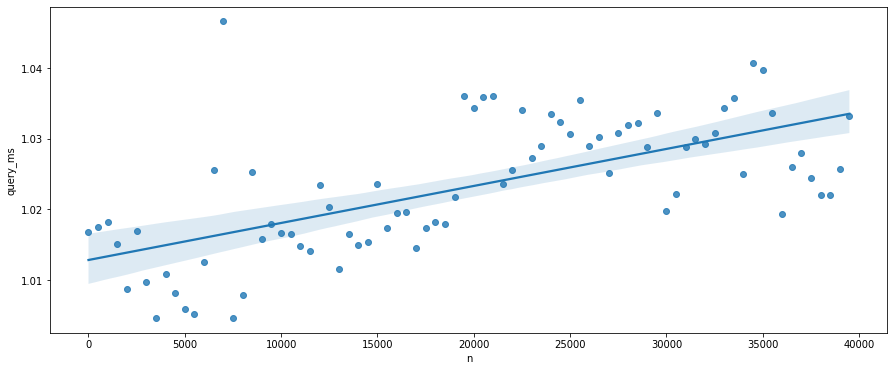

<IPython.core.display.Javascript object>

In [258]:
%%time
import time
import random

test_shingles = list(df_test["shingles"].sample(100))
speedtest = []
lsh = MinHashLSH(threshold=j_threshold, num_perm=n_hashes)
for i, row_shingles in enumerate(shingles):
    lsh.insert(i, datasketch_minhash(row_shingles))
    if i % 500 == 0:
        for s in test_shingles:
            start = time.perf_counter()
            lsh.query(
        datasketch_minhash(s)
    )
            speedtest.append((i, (time.perf_counter() - start) * 1000.0))
            
fig = plt.figure(figsize=(15, 6))
_=sns.regplot(
    data=pd.DataFrame.from_records(speedtest, columns=["n", "query_ms"])
    .groupby("n")
    .min()
    .reset_index(),
    x="n",
    y="query_ms",
)

CPU times: user 6.78 s, sys: 83.1 ms, total: 6.86 s
Wall time: 6.83 s


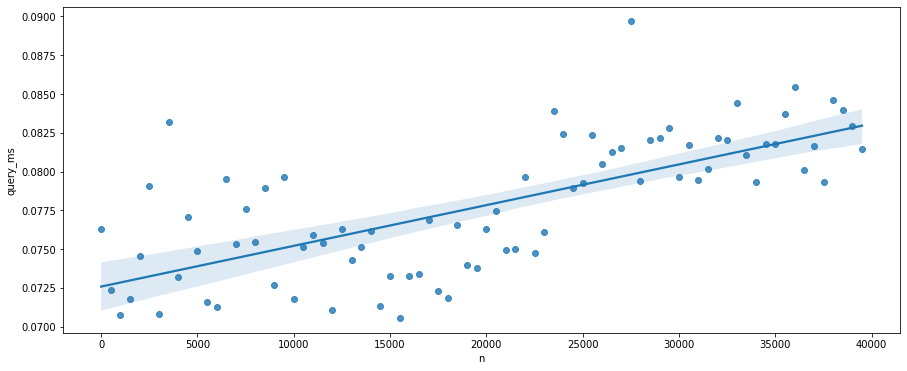

<IPython.core.display.Javascript object>

In [259]:
%%time
import time
import random

test_shingles = list(df_test["shingles"].sample(100))
speedtest = []
lsh = mh.LSH(n_hashes=n_hashes, bands=lsh_lshexp.n_bands)
for i, row_shingles in enumerate(shingles):
    lsh.insert(lsh_lshexp_minhash(row_shingles), i)
    if i % 500 == 0:
        for s in test_shingles:
            start = time.perf_counter()
            lsh.best_hits(lsh_lshexp_minhash(s))
            speedtest.append((i, (time.perf_counter() - start) * 1000.0))
            
fig = plt.figure(figsize=(15, 6))
_=sns.regplot(
    data=pd.DataFrame.from_records(speedtest, columns=["n", "query_ms"])
    .groupby("n")
    .min()
    .reset_index(),
    x="n",
    y="query_ms",
)

CPU times: user 6.61 s, sys: 103 ms, total: 6.71 s
Wall time: 6.7 s


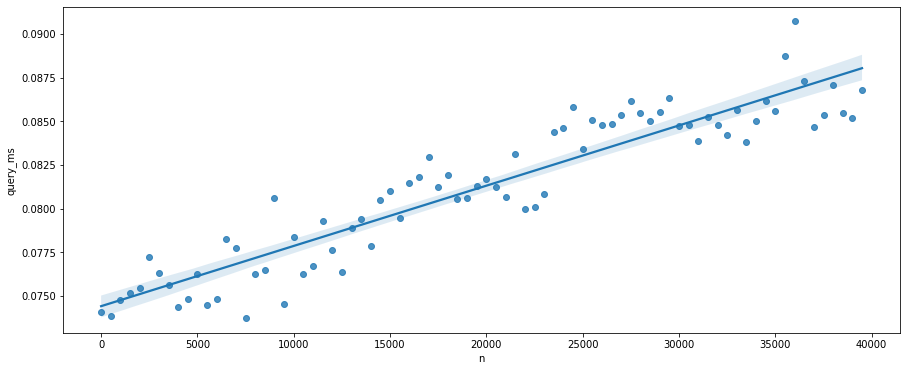

<IPython.core.display.Javascript object>

In [260]:
%%time
import time
import random

test_shingles = list(df_test["shingles"].sample(100))
speedtest = []
lsh = mh.LSH(n_hashes=n_hashes, bands=lsh_lshexp.n_bands)
for i, row_shingles in enumerate(shingles):
    lsh.insert(minhash_fog_fn(row_shingles), i)
    if i % 500 == 0:
        for s in test_shingles:
            start = time.perf_counter()
            lsh.best_hits(minhash_fog_fn(s))
            speedtest.append((i, (time.perf_counter() - start) * 1000.0))
            
fig = plt.figure(figsize=(15, 6))
_=sns.regplot(
    data=pd.DataFrame.from_records(speedtest, columns=["n", "query_ms"])
    .groupby("n")
    .min()
    .reset_index(),
    x="n",
    y="query_ms",
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>